In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#### Quadrant Model

Given NWP data, for each init_time and forecast horizon, downsample the geospatial grid into 4 quadrants (2x2 grid per channel). This extends our feature space from 23 variables (17+6) to 74 (4*17 + 6).

In [2]:
from gradboost_pv.models.quadrant import build_datasets_from_local, load_local_preprocessed_slice
from gradboost_pv.models.utils import NWP_FPATH, GSP_FPATH

gsp = xr.open_zarr(GSP_FPATH)
nwp = xr.open_zarr(NWP_FPATH)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)


In [3]:
from gradboost_pv.models.training import run_experiment, plot_feature_importances, plot_loss_metrics

results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X = load_local_preprocessed_slice(step)
    X, y = build_datasets_from_local(X, gsp, nwp.coords["step"].values[step])
    output = run_experiment(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


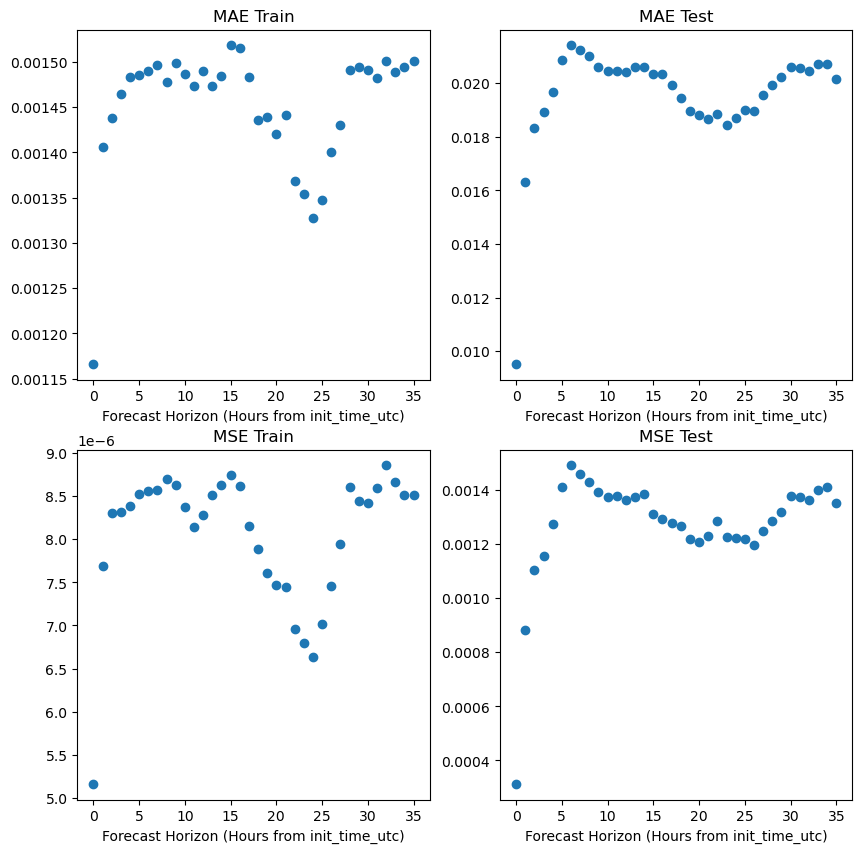

In [6]:
plot_loss_metrics(results)

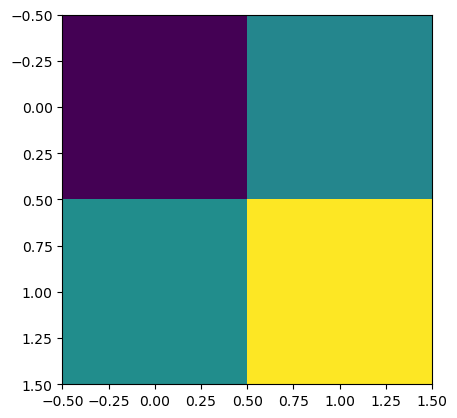

In [7]:
plt.imshow(X[["cdcb_1", "cdcb_2", "cdcb_3", "cdcb_4"]].values.reshape(len(X), 2, 2)[0])

#### Comment:

The performance of the quadrant features is lower than that of the base model with the more granular channel-mean features. It does seem to able to use the NWP data as well for splits, as demonstrated in the feature importance plots. Move onto to the uk-region filtered model before further investigation in this area.